In [1]:
from langchain_core.messages import HumanMessage, BaseMessage
# from decouple import config
from typing import List, Sequence
import pprint
import os
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from gemini_llm import GeminiLLM


/Users/pdwivedi/miniconda3/envs/llm_agents/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
os.environ["GOOGLE_API_KEY"] = os.getenv("OPENAI_API_KEY") ## Put your OpenAI API key here
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY") ## Put your Langsmith API key here
os.environ["LANGCHAIN_HUB_API_KEY"] = os.getenv("LANGCHAIN_API_KEY") ## Put your Langsmith API key here
os.environ["LANGCHAIN_TRACING_V2"] = 'true' ## Set this as True
os.environ["LANGCHAIN_ENDPOINT"] = 'https://api.smith.langchain.com/' ## Set this as: https://api.smith.langchain.com/
os.environ["LANGCHAIN_HUB_API_URL"] = 'https://api.hub.langchain.com' ## Set this as : https://api.hub.langchain.com
os.environ["LANGCHAIN_PROJECT"] = 'llm-agents-planning'

## Define prompts for Generation and Reflection

![Reflection](images/reflection.png)

In [14]:
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI assistant researcher tasked with sharing recipes based on the user's request. Share your top 3 recipes"
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

llm = GeminiLLM(model='gemini-1.5-flash-latest', temperature=0.3)

generate_agent = generation_prompt | llm

In [15]:
result = generate_agent.invoke({"messages": ["Share breakfast recipes"]})
pprint.pprint(result)

('Here are 3 breakfast recipes for you:\n'
 '\n'
 '**1.  Overnight Oats**\n'
 '\n'
 '* **Ingredients:**\n'
 '    * 1/2 cup rolled oats\n'
 '    * 1/2 cup milk (any kind)\n'
 '    * 1/4 cup yogurt (Greek or regular)\n'
 '    * 1 tablespoon chia seeds\n'
 '    * 1 teaspoon honey or maple syrup (optional)\n'
 '    * 1/4 teaspoon vanilla extract\n'
 '    * Toppings of your choice (fruit, nuts, granola)\n'
 '\n'
 '* **Instructions:**\n'
 '    1. Combine all ingredients in a jar or container.\n'
 '    2. Stir well and refrigerate overnight.\n'
 '    3. In the morning, top with your favorite toppings and enjoy!\n'
 '\n'
 '**2.  Scrambled Eggs with Avocado Toast**\n'
 '\n'
 '* **Ingredients:**\n'
 '    * 2 eggs\n'
 '    * 1/4 avocado, mashed\n'
 '    * 1 slice whole-wheat toast\n'
 '    * Salt and pepper to taste\n'
 '\n'
 '* **Instructions:**\n'
 '    1. Toast the bread.\n'
 '    2. Scramble the eggs with salt and pepper.\n'
 '    3. Spread the mashed avocado on the toast.\n'
 '    4. Top wit

In [6]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        #  this needs to be a tuple so do not forget the , at the end
        (
            "system",
            "You are a food critic who focuses specially on healthy organic food."
            "Provide detailed feedback to the recipes presented to you to make them healthy."
            "You also want to focus on food that is protien rich, not very fatty and not with too much meat"
            "Provide your feedback as a numbered list"
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect_agent = reflection_prompt | llm

In [16]:
result = reflect_agent.invoke({"messages": [result]})
pprint.pprint(result)

('Here is my feedback on the breakfast options, focusing on healthy, '
 'protein-rich, low-fat, and minimal meat:\n'
 '\n'
 "1. **Overnight Oats:** This is a great start! It's naturally low in fat and "
 "a good source of fiber. Here's how to make it even healthier and "
 'protein-rich:\n'
 '\n'
 '    * **Swap the milk:** Opt for unsweetened almond milk, soy milk, or oat '
 'milk for a lower calorie and fat option.\n'
 '    * **Boost the protein:** Add a scoop of protein powder (whey, soy, or '
 'plant-based) to the mix.\n'
 '    * **Choose healthy toppings:**  Instead of honey or maple syrup, '
 'consider a drizzle of natural peanut butter or a sprinkle of cinnamon for '
 'sweetness.  Choose berries, chopped nuts, or seeds for toppings.\n'
 '\n'
 "2. **Scrambled Eggs with Avocado Toast:** This is a solid choice, but let's "
 'make it even better:\n'
 '\n'
 '    * **Whole eggs are best:**  While some people prefer egg whites, whole '
 'eggs provide more nutrients, including choline, wh

## Define the Langgraph Graph

In [18]:
from langgraph.graph import MessageGraph, END

### Define generate and reflect nodes

In [17]:
async def generation_node(state: Sequence[BaseMessage]):
    return await generate_agent.ainvoke({"messages": state})

async def reflection_node(state: Sequence[BaseMessage]):
    return await reflect_agent.ainvoke({"messages": state})


In [19]:
builder = MessageGraph()
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.set_entry_point("generate")


def should_continue(state: List[BaseMessage]):
    if len(state) > 4:
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
graph = builder.compile()

In [20]:
graph.get_graph().print_ascii()

                +-----------+              
                | __start__ |              
                +-----------+              
                       *                   
                       *                   
                       *                   
                 +----------+              
                 | generate |              
                 +----------+              
                **           **            
              **               **          
            **                   **        
+-----------------+                **      
| should_continue |                 *      
+-----------------+**               *      
          *          *****          *      
          *               ****      *      
          *                   ***   *      
    +---------+               +---------+  
    | __end__ |               | reflect |  
    +---------+               +---------+  


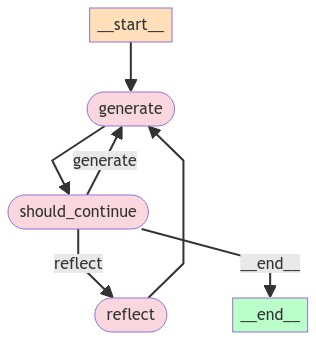

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

### Start graph execution

In [22]:
async for event in graph.astream(
    [
        HumanMessage(
            content="Share some breakfast recipes"
        )
    ],
):
    print(event)
    print("---")

Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'generate': 'Here are three breakfast recipes for you:\n\n1. **Overnight Oats:** \n    * Combine 1/2 cup rolled oats, 1/2 cup milk (dairy or non-dairy), 1/4 cup yogurt, 1 tablespoon chia seeds, and a drizzle of honey or maple syrup in a jar. \n    * Stir well and refrigerate overnight. \n    * In the morning, top with your favorite fruits, nuts, or seeds.\n\n2. **Breakfast Burrito:**\n    * Scramble 2 eggs with a sprinkle of salt and pepper. \n    * Warm a large flour tortilla in a pan. \n    * Fill the tortilla with scrambled eggs, shredded cheese, diced tomatoes, and your choice of protein (like beans, sausage, or bacon). \n    * Fold the tortilla and enjoy!\n\n3. **Avocado Toast:**\n    * Toast a slice of bread. \n    * Mash half an avocado with a fork and spread it on the toast. \n    * Season with salt, pepper, and a squeeze of lemon juice. \n    * Top with a sprinkle of red pepper flakes for a bit of heat. \n'}
---


Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'reflect': "As a health-focused food critic, here's my feedback on your breakfast recipes:\n\n1. **Overnight Oats:** This is a great start!  Overnight oats are a fantastic way to get a protein-rich, fiber-filled breakfast. Here's how to make it even healthier:\n\n    * **Swap the milk:** Opt for unsweetened almond milk, soy milk, or oat milk for a lower-calorie, lower-fat option.\n    * **Reduce the sugar:**  Honey and maple syrup are added sugars. Use a small amount of natural sweetener like stevia or a sprinkle of cinnamon for flavor instead.\n    * **Boost the protein:** Add a scoop of protein powder to your oats for a more filling and satiating breakfast.\n    * **Go for healthy toppings:**  Instead of just fruit, add a handful of nuts and seeds for healthy fats and extra protein.\n\n2. **Breakfast Burrito:**  While delicious, the breakfast burrito needs some serious adjustments to fit my healthy criteria. \n\n    * **Skip the flour tortilla:** Opt for a whole-wheat tortilla or a 

Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'generate': '## Revised Breakfast Recipes (Health-Focused)\n\nHere are three revised breakfast recipes, incorporating your feedback for a healthier and more nutritious start to your day:\n\n**1. Power-Packed Overnight Oats:**\n\n* **Ingredients:**\n    * 1/2 cup rolled oats\n    * 1/2 cup unsweetened almond milk (or soy/oat milk)\n    * 1/4 cup plain Greek yogurt\n    * 1 tablespoon chia seeds\n    * 1/4 teaspoon cinnamon (or a small amount of stevia)\n    * 1 scoop protein powder (optional)\n* **Instructions:**\n    * Combine all ingredients in a jar and stir well.\n    * Refrigerate overnight.\n    * In the morning, top with a handful of chopped nuts (almonds, walnuts, pecans), seeds (pumpkin, flax, sunflower), and fresh berries.\n\n**2. Veggie-Packed Breakfast Burrito:**\n\n* **Ingredients:**\n    * 1 whole-wheat tortilla (or lettuce wrap)\n    * 2 eggs (scrambled with a sprinkle of salt and pepper)\n    * 1/2 cup cooked black beans\n    * 1/4 cup chopped bell pepper\n    * 1/4 cup

Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'reflect': "##  Health-Focused Food Critic's Feedback on Revised Breakfast Recipes:\n\nYou've made some great improvements to these breakfast recipes, focusing on protein, fiber, and minimizing added sugars and unhealthy fats. Here's my detailed feedback:\n\n**1. Power-Packed Overnight Oats:**\n\n* **Excellent:**  The use of unsweetened almond milk, Greek yogurt, and chia seeds is a fantastic choice for protein and healthy fats. \n* **Suggestion:** Consider adding a small amount of ground flaxseed for extra fiber and omega-3 fatty acids.\n* **Suggestion:**  While the optional protein powder is a good addition, you could also consider adding a tablespoon of nut butter for a more satiating and flavorful experience.\n\n**2. Veggie-Packed Breakfast Burrito:**\n\n* **Excellent:**  The use of whole-wheat tortillas, black beans, and a variety of vegetables is a great way to boost fiber and nutrients. \n* **Suggestion:**  Consider using a low-sodium salsa for a flavorful and healthy addition.

Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'generate': '##  Health-Focused Breakfast Recipes (Final Version)\n\nHere are the final versions of the breakfast recipes, incorporating all the feedback from the health-focused food critic:\n\n**1. Power-Packed Overnight Oats:**\n\n* **Ingredients:**\n    * 1/2 cup rolled oats\n    * 1/2 cup unsweetened almond milk (or soy/oat milk)\n    * 1/4 cup plain Greek yogurt\n    * 1 tablespoon chia seeds\n    * 1 tablespoon ground flaxseed\n    * 1/4 teaspoon cinnamon (or a small amount of stevia)\n    * 1 scoop protein powder (optional)\n    * 1 tablespoon nut butter (optional)\n* **Instructions:**\n    * Combine all ingredients in a jar and stir well.\n    * Refrigerate overnight.\n    * In the morning, top with a handful of chopped nuts (almonds, walnuts, pecans), seeds (pumpkin, flax, sunflower), and fresh berries.\n\n**2. Veggie-Packed Breakfast Burrito:**\n\n* **Ingredients:**\n    * 1 whole-wheat tortilla (or lettuce wrap)\n    * 2 eggs (scrambled with a sprinkle of salt and pepper)\n